<a href="https://colab.research.google.com/github/karyapoormohamadie/stock_market_model/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [ ]:
now = str(datetime.datetime.now())[:9]

data = yf.download('GOOGL','2018-01-01',now,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.shape

(1677, 6)

In [ ]:
data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1.677000e+03
mean,98.047292,99.150999,97.010965,98.107530,97.872079,3.413451e+07
std,36.574060,36.928319,36.238103,36.583241,36.507219,1.537472e+07
min,49.216000,50.605999,48.882999,49.233501,49.111893,9.312000e+06
25%,61.102001,61.745499,60.594002,61.056999,60.906185,2.431200e+07
50%,95.419998,96.930000,94.110001,95.510002,95.274086,3.039330e+07
75%,130.759995,132.092499,129.000000,130.250000,129.928268,3.890840e+07
max,190.309998,191.750000,189.029999,191.179993,190.926636,1.331780e+08


In [ ]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999647,0.999630,0.999184,0.999185,-0.239096
High,0.999647,1.000000,0.999585,0.999624,0.999624,-0.232634
Low,0.999630,0.999585,1.000000,0.999663,0.999663,-0.248421
Close,0.999184,0.999624,0.999663,1.000000,1.000000,-0.241928
Adj Close,0.999185,0.999624,0.999663,1.000000,1.000000,-0.241953
Volume,-0.239096,-0.232634,-0.248421,-0.241928,-0.241953,1.000000


In [ ]:
data = data.sort_index()

<Axes: ylabel='Volume'>

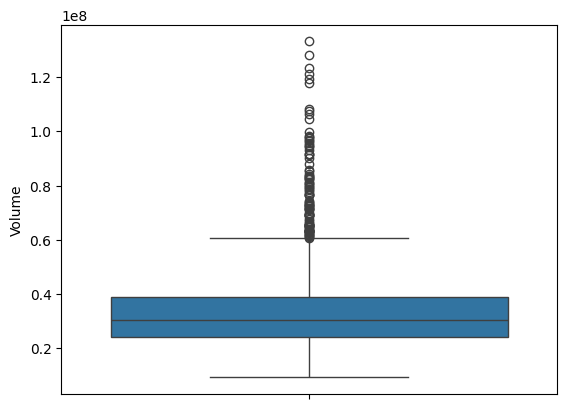

In [ ]:
sns.boxplot(data.Volume)

In [ ]:
import plotly.graph_objects as go

In [ ]:
def tracer(Y):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=data.index,y=Y,mode='lines'))

  fig.show()

In [ ]:
tracer(data['Open'])

In [ ]:
tracer(data['Close'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tnrange
import pickle

In [ ]:
1677 * 0.2

335.40000000000003

In [ ]:
test_lengh = data[(data.index > '2023-01-01')].shape[0]
test_lengh

418

In [ ]:
def create_featurs(data,feature_length):

  x=[]
  y=[]

  for i in tnrange(len(data) - feature_length):
    x.append(data.iloc[i : i + feature_length].values)
    y.append(data['Close'].values[i + feature_length])

  x = np.array(x)
  y = np.array(y)

  return x,y



In [ ]:
x , y = create_featurs(data,32)

  0%|          | 0/1645 [00:00<?, ?it/s]

In [ ]:
x_train , x_test , y_train , y_test = x[:-test_lengh] , x[-test_lengh:] ,y[:-test_lengh] , y[-test_lengh:]

In [ ]:
class MultiDimentionScaler():
  def __init__(self):
    self.scalers = []

  def fit_transform(self , X):
    total_dim = X.shape[2]
    for i in range(total_dim):
      Scaler = MinMaxScaler()
      X[:,:,i] = Scaler.fit_transform(X[:,:,i])
      self.scalers.append(Scaler)
    return X

  def transform(self,X):
    for i in range(X.shape[2]):
      X[:,:,i] = self.scalers[i].transform(X[:,:,i])
    return X



In [ ]:
feature_scaler = MultiDimentionScaler()

x_train = feature_scaler.fit_transform(x_train)
x_test = feature_scaler.transform(x_test)


In [ ]:
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train.reshape(-1,1))
y_test = target_scaler.transform(y_test.reshape(-1,1))


In [ ]:
def save(obj ,name:str):
  path = open(f'{name}.pck','wb')
  pickle.dump(obj,path)
  path.close

def load(obj,name):
  path = open(f'{name}.pck','rb')
  lo = pickle.load(path)
  return lo

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau


In [ ]:
checkpoint = ModelCheckpoint('/content/checkpoints/model.weights.h5',monitor = 'val_loss',mode='min',save_best_only=True,save_weights_only=True)
learn_rate_reducer = ReduceLROnPlateau(factor = 0.25,patience=5,min_lr=0.0001)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
model = Sequential()

model.add(layers.Input((32,6)))

model.add(layers.Bidirectional(layers.LSTM(512,return_sequences=True,recurrent_dropout=0.1)))
model.add(layers.LSTM(256,recurrent_dropout=0.1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64,activation='elu'))
model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(32,activation='elu'))
model.add(layers.Dense(1,activation='linear'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),loss='mse')


In [ ]:
x_train.shape,x_test.shape

((1227, 32, 6), (418, 32, 6))

In [ ]:
model.fit(x_train,y_train
          ,epochs=15,
          verbose=1,
          batch_size=1,
          validation_data=(x_test,y_test),
          callbacks=[checkpoint,learn_rate_reducer],
          shuffle=False)

Epoch 1/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 352s 285ms/step - loss: 0.0037 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 2/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 364s 270ms/step - loss: 0.0100 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 3/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 381s 270ms/step - loss: 0.0077 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 4/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 376s 264ms/step - loss: 0.0058 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 5/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 379s 262ms/step - loss: 0.0054 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 6/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 323s 263ms/step - loss: 0.0045 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 7/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 381s 262ms/step - loss: 0.0039 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 8/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 320s 261ms/step - loss: 0.0036 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 9/15
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 322s 263ms/step - loss: 0.0031

In [ ]:
model.

In [ ]:
model.load_weights('/content/checkpoints/model.weights.h5')
prediction = model.predict(x_test)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/checkpoints/model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
prediction = target_scaler.inverse_transform(prediction)
actual = target_scaler.inverse_transform(y_test)

In [ ]:
prediction.shape,prediction[0]

((418, 1), array([92.07654], dtype=float32))

In [ ]:
prediction = np.squeeze(prediction,axis=1)
actual = np.squeeze(actual,axis=1)

In [ ]:
model.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=prediction , mode='lines',name='predicted'))
fig.add_trace(go.Scatter(x=data.index[-test_lengh:],y=actual , mode='lines',name='actual'))

fig.show()